# Read clusters

In [1]:
#add the dev version of aare
import sys; sys.path.append('/home/l_msdetect/erik/aare/build')
from helpers import nb_aare_version
nb_aare_version()

#Our normal python imports
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

Example run on: **2025-01-15 08:18** with aare: **dev**

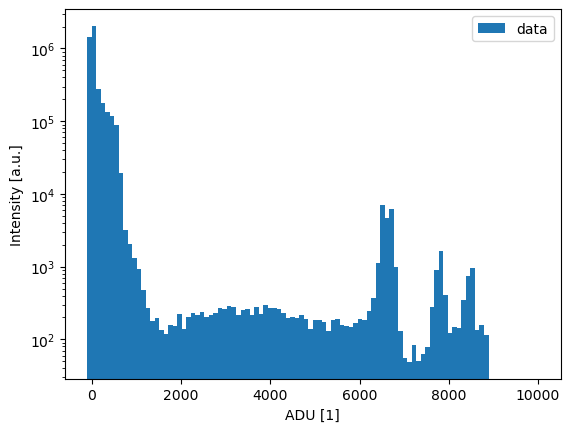

In [2]:
from aare import ClusterFile
import boost_histogram as bh


base = Path('/mnt/sls_det_storage/matterhorn_data/aare_test_data/ci/aare_test_data/clusters/')
fname = 'beam_En700eV_-40deg_300V_10us_d0_f0_100.clust'


# Create the histogram
n_bins = 100
xmin = -100
xmax = 1e4
hist1 = bh.Histogram(bh.axis.Regular(n_bins, xmin, xmax))

#Read clusters and fill the histogram with pixel values
with ClusterFile(base/fname, chunk_size = 10000) as f:
    for clusters in f:
        arr = np.array(clusters, copy = False)
        hist1.fill(arr['data'].flat)



#Plotting
fig, ax = plt.subplots()
ax.bar(hist1.axes[0].centers, hist1.values(), width=hist1.axes[0].widths, label = 'data')
ax.set_yscale('log')
ax.set_xlabel('ADU [1]')
ax.set_ylabel('Intensity [a.u.]')
ax.legend()

## Sanity check using pure python

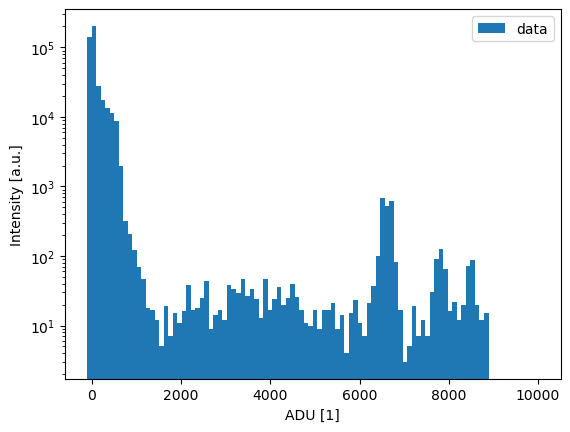

In [3]:
n_bins = 100
xmin = -100
xmax = 1e4
hist1 = bh.Histogram(bh.axis.Regular(n_bins, xmin, xmax))
with open(base/fname, 'rb') as f:
    for i in range(100):
        frame_number = np.fromfile(f, count=1, dtype = np.int32)
        n_clusters = np.fromfile(f, count=1, dtype = np.uint32)[0]
#         print(frame_number, n_clusters)
        for i in range(n_clusters):
            xy = np.fromfile(f, count=2, dtype = np.uint16)
            data = np.fromfile(f, count=9, dtype = np.int32)
            hist1.fill(data)
    
#Plotting
fig, ax = plt.subplots()
ax.bar(hist1.axes[0].centers, hist1.values(), width=hist1.axes[0].widths, label = 'data')
ax.set_yscale('log')
ax.set_xlabel('ADU [1]')
ax.set_ylabel('Intensity [a.u.]')
ax.legend()